# 02_PyTorch_Classification

Classification is a problem of predicting whether something is one thing or another (there can be multiple things as the options).

## 1. Make classdification data and get it ready

In [79]:
import sklearn
import torch
from torch import nn

print(sklearn.__version__)
print(torch.__version__)

1.6.1
2.8.0+cu128


In [80]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles - X are the features, y are the labels (0: outer circle, 1: inner circle)
X, y = make_circles(n_samples,
                      noise=0.03,
                      random_state=42)
print(X.shape, y.shape)

# View the first 5 samples
print(f"First 5 samples of X:\n{X[:5]}")
print(f"First 5 samples of y:\n{y[:5]}")

(1000, 2) (1000,)
First 5 samples of X:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
[1 1 1 1 0]


In [81]:
# Make dataframe of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y})
circles.head(10)

X1        X2  label
0  0.754246  0.231481      1
1 -0.756159  0.153259      1
2 -0.815392  0.173282      1
3 -0.393731  0.692883      1
4  0.442208 -0.896723      0
5 -0.479646  0.676435      1
6 -0.013648  0.803349      1
7  0.771513  0.147760      1
8 -0.169322 -0.793456      1
9 -0.121486  1.021509      0

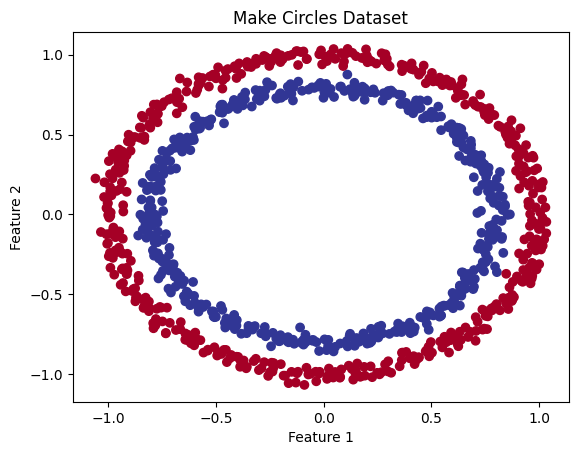

In [82]:
# Visualize, Visualize, and Visualize!
import matplotlib.pyplot as plt
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Make Circles Dataset")
plt.show()

### 1.1 Check input and output data

In [83]:
# View the first examples of the features and labels
X_sample = X[0]
y_sample = y[0]
print(f"First sample of X: {X_sample}, shape: {X_sample.shape}")
print(f"First sample of y: {y_sample}, shape: {y_sample.shape}")

First sample of X: [0.75424625 0.23148074], shape: (2,)
First sample of y: 1, shape: ()


### 1.2 Turn data into tensors and create train and test splits

In [84]:
# Turn data into tensors
X = torch.tensor(X).type(torch.float)
y = torch.tensor(y).type(torch.float)
print(type(X), X.dtype, y.dtype)

<class 'torch.Tensor'> torch.float32 torch.float32


In [85]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2,  # 20% test, 80% train
                                                    random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


torch.Size([800, 2]) torch.Size([200, 2]) torch.Size([800]) torch.Size([200])


## 2. Building a model

Build a model to classify our blue and red dots.

To do so, we want to:

1. Setup device agonistic code so our code will run on an accelerator (GPU) if there is one
2. Construct a model (by subclassing `nn.Module`)
3. Define a loss funciton and optimizer
4. Create a training and test loop

In [86]:
# Make device agnostic code 
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [87]:
from sklearn import datasets
# Constructing a model
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()

        # Create 2 linear layers
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # hidden layer, generally the out_features is an multiple of 8
        self.layer_2 = nn.Linear(in_features=5, out_features=1)

        self.two_linear_layers = nn.Sequential(
            self.layer_1,
            self.layer_2
        )

    # Define the forward pass   
    def forward(self, x):
        return self.layer_2(self.layer_1(x)) # x -> layer_1 --> layer_2 --> output
    
# Instantiate the model
model_0 = CircleModelV0().to(device)
print(model_0, "\n", device)

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
  (two_linear_layers): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): Linear(in_features=5, out_features=1, bias=True)
  )
) 
 cuda


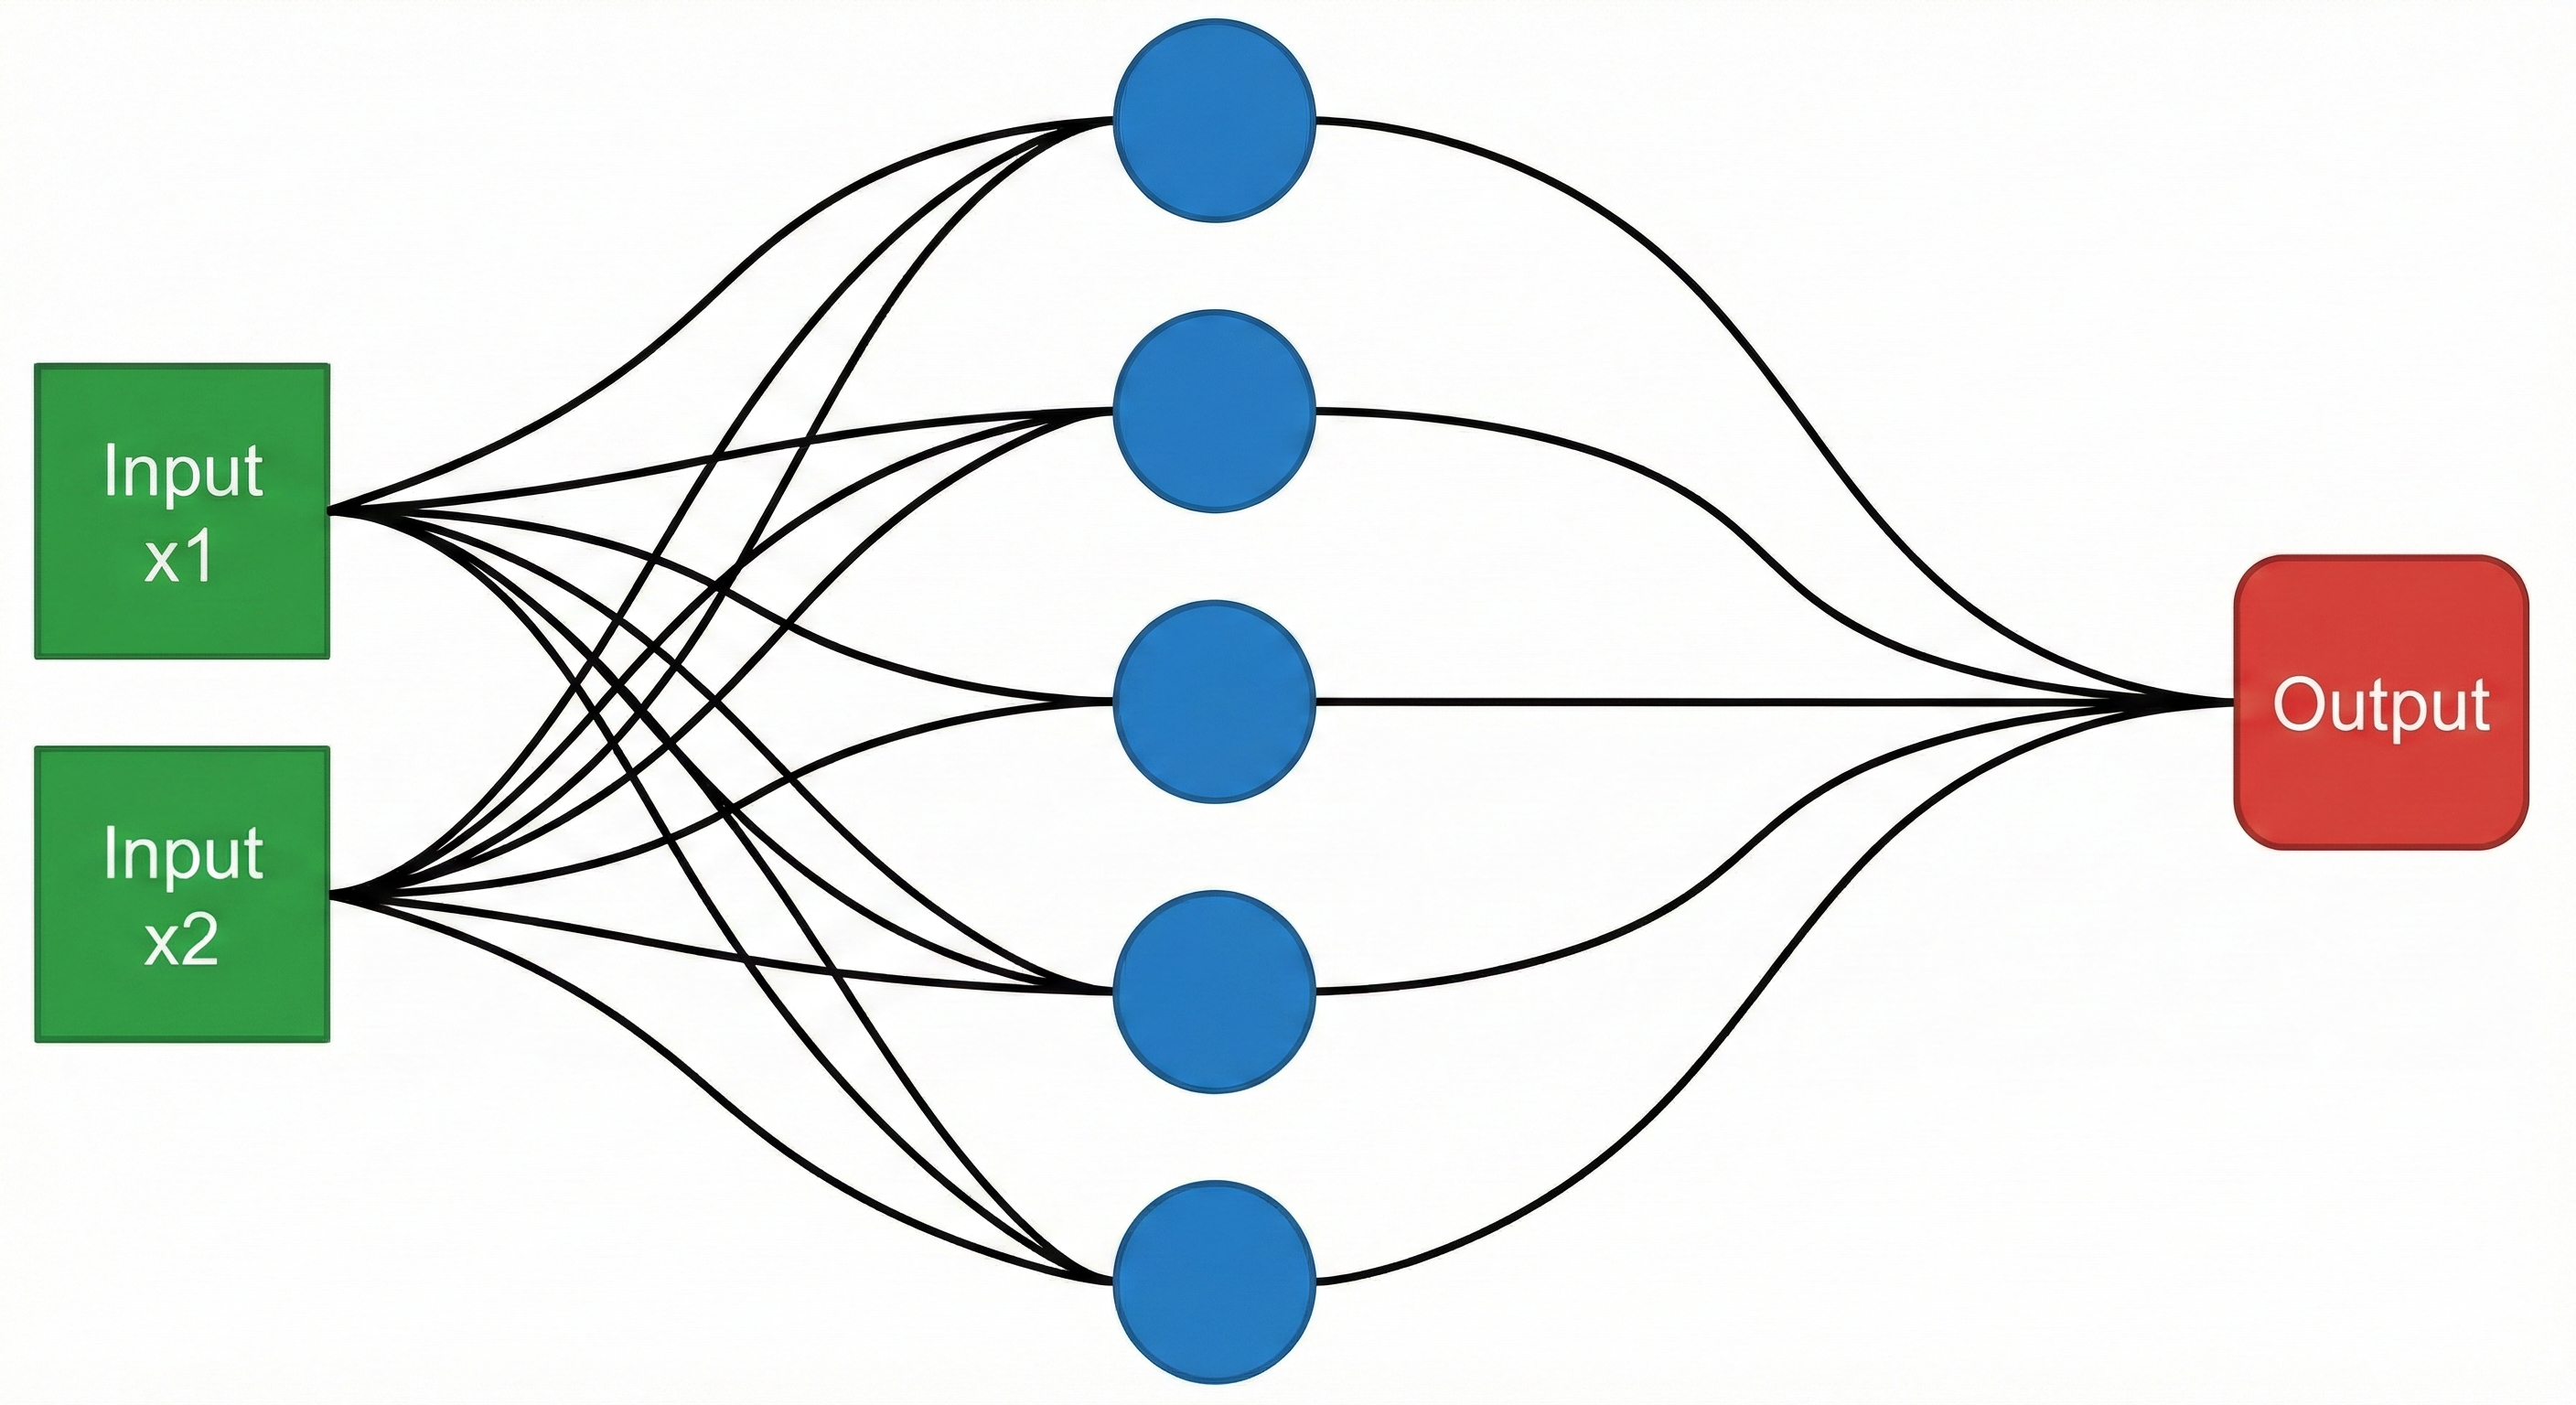

In [88]:
# Let's replicate the model above using nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

print(model_0)
print(model_0.state_dict())

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)
OrderedDict([('0.weight', tensor([[-0.1854,  0.4286],
        [ 0.6667,  0.0991],
        [-0.1697, -0.1850],
        [ 0.0431, -0.0685],
        [-0.2585, -0.2056]], device='cuda:0')), ('0.bias', tensor([ 0.6408, -0.1100,  0.2205, -0.3385,  0.0099], device='cuda:0')), ('1.weight', tensor([[-0.3184, -0.1491, -0.1847, -0.1640,  0.0949]], device='cuda:0')), ('1.bias', tensor([-0.0126], device='cuda:0'))])


In [89]:
# Make predictions
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
print(f"Length of untrained predictions: {len(untrained_preds)} | Shape: {untrained_preds.shape}")
print(f"Length of test labels: {len(X_test)} | Shape: {X_test.shape}")
print(f"\nFirst 10 untrained predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of untrained predictions: 200 | Shape: torch.Size([200, 1])
Length of test labels: 200 | Shape: torch.Size([200, 2])

First 10 untrained predictions:
tensor([[-0.2548],
        [-0.3054],
        [-0.1165],
        [-0.2940],
        [-0.1076],
        [-0.1386],
        [-0.2882],
        [-0.2491],
        [-0.1171],
        [-0.3087]], device='cuda:0')

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setup loss function and optimizer

Which loss function or optimizer should use?

-> For classification you might want **binary cross entropy** or **categorical cross entropy** (cross entropy).

* Loss Function - `torch.nn.BECWithLogitsLoss()`

In [90]:
# Setup loss function
loss_fn = nn.BCEWithLogitsLoss() # For binary classification

# Setup optimizer
optimizer = torch.optim.SGD(model_0.parameters(), lr=0.1)



In [91]:
# Calculate acccuracy - out of 100 samples, how many are predicted correctly
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

## 3. Train model

To train our model, we are going to build a training loop:

1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward (backpropagation)
5. Optimizer step (gradient descent)

### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

Our model outputs are going to be raw **logits**.

We can convert these **logits** into **prediction probabilities** by passing them to some kind of activation function (e.g. sigmoid for binary classification and softmax for multiclass classification)

Then we can convert our model's prediction probabilities to **prediction labels** by either rounding them or taking the `argmax()`

In [92]:
# View the first 5 outputs of the forward pass on the test data
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
print(y_logits)

tensor([[-0.2548],
        [-0.3054],
        [-0.1165],
        [-0.2940],
        [-0.1076]], device='cuda:0')


For our prediction probability values, we need to perform a range-style rounding on them:
* `y_pred_probs` >= 0.5, `y = 1` (class 1)
* `y_pred_probs` < 0.5, `y = 0` (class 0)

In [93]:
# Use the sigmoid function to convert logits -> prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
print(y_pred_probs)

tensor([[0.4366],
        [0.4242],
        [0.4709],
        [0.4270],
        [0.4731]], device='cuda:0')


In [94]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full (logits -> pred probs -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimensions
y_preds.squeeze()
print(y_preds.squeeze())

print(y_test[:5])


tensor([True, True, True, True, True], device='cuda:0')
tensor([0., 0., 0., 0., 0.], device='cuda:0')
tensor([1., 0., 1., 0., 1.])


### 3.2 Building a training and evaluation loop in PyTorch

In [99]:
# Set random seed
torch.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass
    y_logits = model_0(X_train).squeeze() # squeeze to remove extra dimensions
    y_pred = torch.round(torch.sigmoid(y_logits)) # get the predicted labels

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # 3. Zero gradients
    optimizer.zero_grad()

    # 4. Backward pass (backpropagation)
    loss.backward()

    # 5. Update weights (gradient descent)
    optimizer.step()

    ### Evaluation / Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate loss/accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Train Loss: {loss:.5f}, Train Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Train Loss: 0.69893, Train Acc: 50.00% | Test Loss: 0.69525, Test Acc: 50.00%
Epoch: 10 | Train Loss: 0.69615, Train Acc: 48.12% | Test Loss: 0.69290, Test Acc: 48.00%
Epoch: 20 | Train Loss: 0.69496, Train Acc: 45.00% | Test Loss: 0.69202, Test Acc: 49.00%
Epoch: 30 | Train Loss: 0.69441, Train Acc: 46.88% | Test Loss: 0.69172, Test Acc: 52.50%
Epoch: 40 | Train Loss: 0.69413, Train Acc: 47.75% | Test Loss: 0.69166, Test Acc: 53.00%
Epoch: 50 | Train Loss: 0.69395, Train Acc: 48.00% | Test Loss: 0.69170, Test Acc: 53.00%
Epoch: 60 | Train Loss: 0.69383, Train Acc: 48.25% | Test Loss: 0.69178, Test Acc: 53.00%
Epoch: 70 | Train Loss: 0.69374, Train Acc: 48.38% | Test Loss: 0.69187, Test Acc: 53.00%
Epoch: 80 | Train Loss: 0.69366, Train Acc: 48.88% | Test Loss: 0.69197, Test Acc: 54.50%
Epoch: 90 | Train Loss: 0.69360, Train Acc: 48.88% | Test Loss: 0.69207, Test Acc: 54.00%


## 4. Make predictions and evaluate the model

From the metrics it looks like our model isn's learning anything...

So to inspect it let's make some predictions and make them visual!

In other words, "**Visualize, Visualize, and Visualize!!!**"

To do so, we are going to import a function called `plot_decision_boundary()` 

In [ ]:
import requests
from pathlib import Path

# Download helper functions script from GitHub
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download.")
else:
    print("Downloading helper_functions.py...")
    url = "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py"
    r = requests.get(url)
    with open("helper_functions.py", "wb") as f:
        f.write(r.content)
from helper_functions import plot_predictions, plot_decision_boundary


helper_functions.py already exists, skipping download.


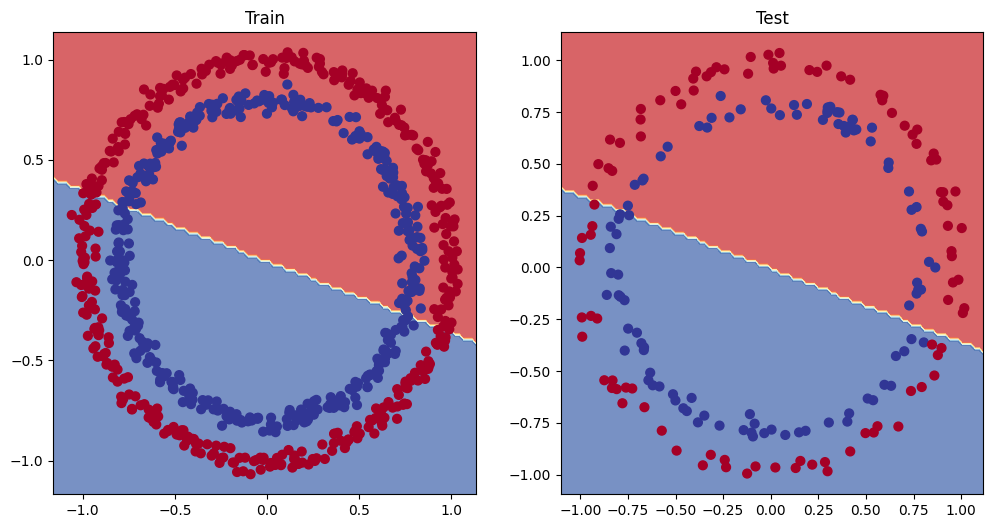

In [106]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_decision_boundary(model_0, X_train, y_train)
plt.title("Train")

plt.subplot(1, 2, 2)
plot_decision_boundary(model_0, X_test, y_test)
plt.title("Test")
plt.show()

## 5. Improving a model (from a model perspective)

* Add more layers - give the model more chance to learn about patterns in the data: go from 2 to 3 layers.
* Add more hidden layers units - go from 5 units to 10 hidden units.
* Fit for longer
* Change the activation function
* Change the learning rate
* Change the loss function

These options are all from a model's perspective because they deal directly with the model, rather than the data.

And because these options are all values we (as machine learning engineers and data scientists) can change, they are reffered as **hyperparameters**

In [ ]:
# Create a new model with more layers and neurons
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features = 2, out_features = 10)
        self.layer_2 = nn.Linear(in_features = 10, out_features = 10)
        self.layer_3 = nn.Linear(in_features = 10, out_features = 1)

    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x)))
    
model_1 = CircleModelV1().to(device)
print(model_1)
    

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)


In [ ]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create a optimizer
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [109]:
# Create a training loop and evaluation loop for model_1
# Set random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Train for longer
epochs = 1000

# Put data to the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Create the training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_1.train()

    # 1. Forward pass
    y_logits = model_1(X_train).squeeze() # squeeze to remove extra dimensions
    y_pred = torch.round(torch.sigmoid(y_logits)) # get the predicted labels

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # 3. Zero gradients
    optimizer.zero_grad()

    # 4. Backward pass (backpropagation)
    loss.backward()

    # 5. Update weights (gradient descent)
    optimizer.step()

    ### Evaluation / Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate loss/accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train Loss: {loss:.5f}, Train Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")


Epoch: 0 | Train Loss: 0.69396, Train Acc: 50.88% | Test Loss: 0.69261, Test Acc: 51.00%
Epoch: 100 | Train Loss: 0.69396, Train Acc: 50.88% | Test Loss: 0.69261, Test Acc: 51.00%
Epoch: 200 | Train Loss: 0.69396, Train Acc: 50.88% | Test Loss: 0.69261, Test Acc: 51.00%
Epoch: 300 | Train Loss: 0.69396, Train Acc: 50.88% | Test Loss: 0.69261, Test Acc: 51.00%
Epoch: 400 | Train Loss: 0.69396, Train Acc: 50.88% | Test Loss: 0.69261, Test Acc: 51.00%
Epoch: 500 | Train Loss: 0.69396, Train Acc: 50.88% | Test Loss: 0.69261, Test Acc: 51.00%
Epoch: 600 | Train Loss: 0.69396, Train Acc: 50.88% | Test Loss: 0.69261, Test Acc: 51.00%
Epoch: 700 | Train Loss: 0.69396, Train Acc: 50.88% | Test Loss: 0.69261, Test Acc: 51.00%
Epoch: 800 | Train Loss: 0.69396, Train Acc: 50.88% | Test Loss: 0.69261, Test Acc: 51.00%
Epoch: 900 | Train Loss: 0.69396, Train Acc: 50.88% | Test Loss: 0.69261, Test Acc: 51.00%


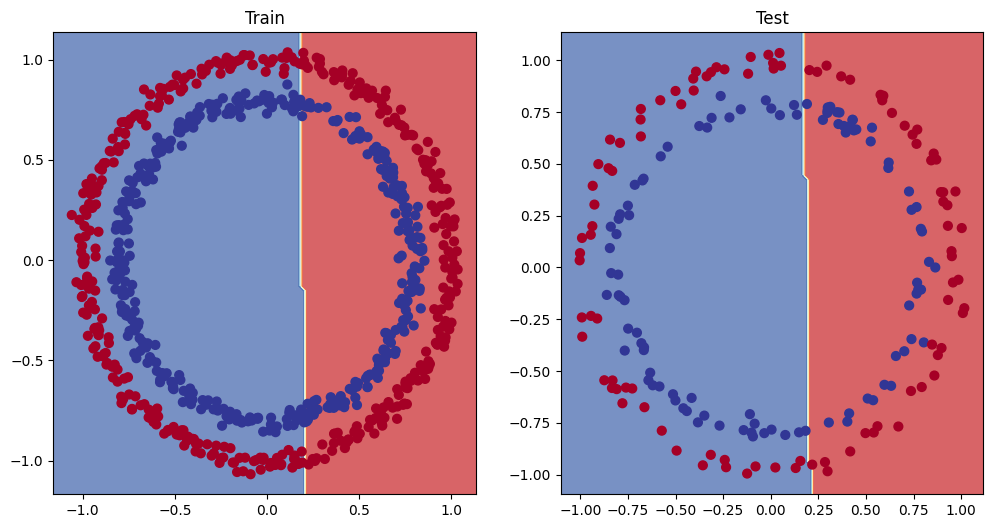

In [110]:
# Plot decision boundary of the new model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_decision_boundary(model_1, X_train, y_train)
plt.title("Train")

plt.subplot(1, 2, 2)
plot_decision_boundary(model_1, X_test, y_test)
plt.title("Test")
plt.show()

### 5.1 Preparing data to see if our model can fit a straight line

One way to troubleshoot to a larger problem is to test out a small problem.


In [112]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # linear regression formula

# Checck the data
print(len(X_regression), len(y_regression))
print(X_regression[:5], "\n", y_regression[:5])

100 100
tensor([[0.0000],
        [0.0100],
        [0.0200],
        [0.0300],
        [0.0400]]) 
 tensor([[0.3000],
        [0.3070],
        [0.3140],
        [0.3210],
        [0.3280]])


In [114]:
# Create train and test splits
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the lengths of each split
print(len(X_train_regression), len(y_train_regression), len(X_test_regression), len(y_test_regression))

80 80 20 20


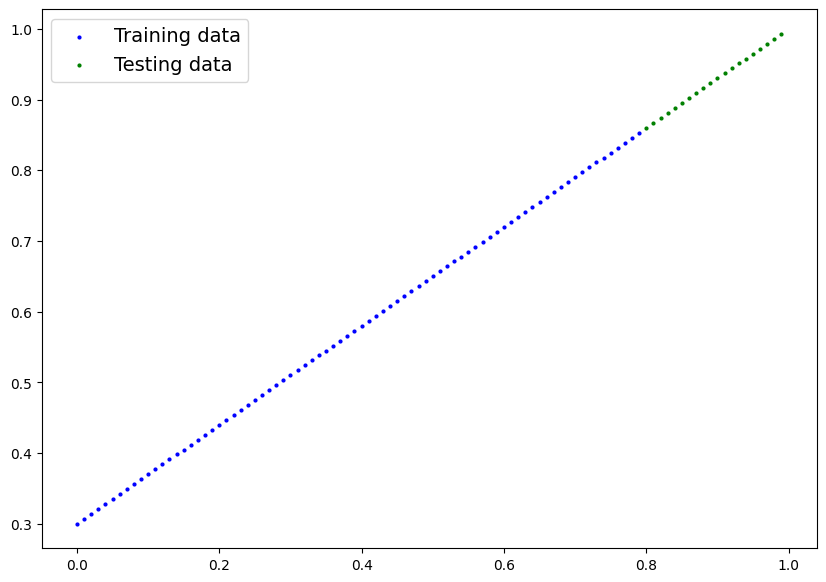

In [115]:
plot_predictions(train_data = X_train_regression,
                 train_labels= y_train_regression,
                 test_data = X_test_regression,
                 test_labels = y_test_regression)

### 5.2 Adjusting  `model_1` to fir a straight line



In [116]:
# Same architecture as model_1 (but using nn.Sequential())
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)
print(model_2)

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)


In [ ]:
# Loss and optimizer
loss_fn = nn.L1Loss()   # MAE
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.1)


In [124]:
# Train the model
# Set random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

# Training
for epoch in range(epochs):
    # Training  
    y_pred = model_2(X_train_regression)
    loss = loss_fn(y_pred, y_train_regression)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Testing 
    model_2.eval()
    with torch.inference_mode():
        test_pred = model_2(X_test_regression)
        test_loss = loss_fn(test_pred, y_test_regression) 
    
    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")

    

Epoch: 0 | Loss: 0.04579 | Test Loss: 0.01590
Epoch: 100 | Loss: 0.06873 | Test Loss: 0.01448
Epoch: 200 | Loss: 0.06813 | Test Loss: 0.00424
Epoch: 300 | Loss: 0.06066 | Test Loss: 0.02271
Epoch: 400 | Loss: 0.06246 | Test Loss: 0.02727
Epoch: 500 | Loss: 0.05112 | Test Loss: 0.00734
Epoch: 600 | Loss: 0.03236 | Test Loss: 0.17832
Epoch: 700 | Loss: 0.00464 | Test Loss: 0.16794
Epoch: 800 | Loss: 0.05017 | Test Loss: 0.00499
Epoch: 900 | Loss: 0.06665 | Test Loss: 0.00416


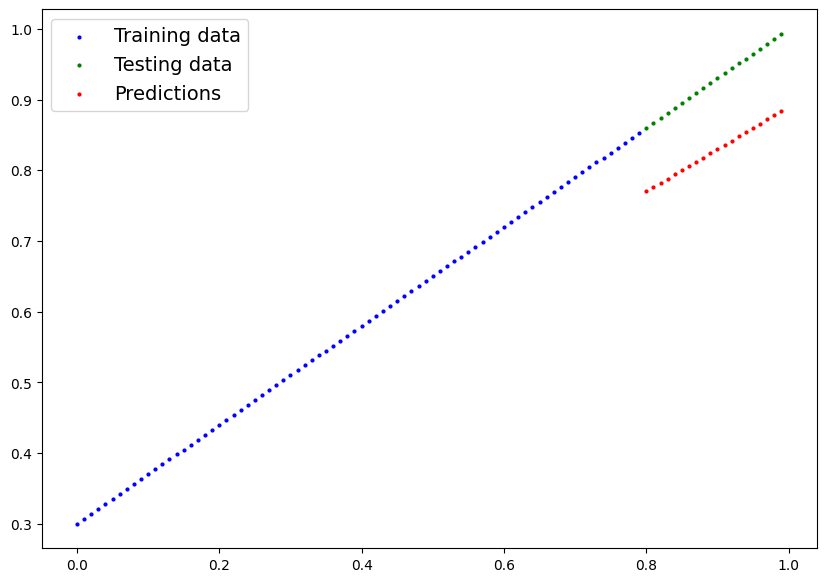

In [125]:
# Turn on evaluation mode   
model_2.eval()

# Make predictions
with torch.inference_mode():
    y_preds = model_2(X_test_regression)

# Plot predictions
plot_predictions(train_data = X_train_regression.cpu(),
                 train_labels= y_train_regression.cpu(),
                 test_data = X_test_regression.cpu(),
                 test_labels = y_test_regression.cpu(),
                 predictions = y_preds.cpu())